<a href="https://colab.research.google.com/github/yisi22/Real-Estate-Investment/blob/main/CondoPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
from datetime import datetime
import math
from functools import reduce
import requests
import json
from dateutil.relativedelta import relativedelta

In [2]:
# !pip install geopy
# !pip install python-dateutil

In [3]:
data = pd.read_csv('/content/ResidentialTransaction_Data_2009to2023.csv', encoding = 'latin1')

In [4]:
data

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,Planning Area
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,Novena
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,Novena
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,Novena
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,Novena
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,River Valley
...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,Bukit Timah
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,Orchard
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,Bukit Timah
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,Bukit Timah


## Find Location

In [5]:
def find_postal(lst, filename):
    '''With the block number and street name, get the full address of the hdb flat,
    including the postal code, geographical coordinates (lat/long)'''

    file = pd.DataFrame()  # Initialize an empty DataFrame

    for index, add in enumerate(lst):
        url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={add}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
        print(index, url)

        try:
            response = requests.get(url)
            data = json.loads(response.text)
        except ValueError:
            print('JSONDecodeError')
            continue  # Skip to the next iteration in case of JSONDecodeError

        temp_df = pd.DataFrame.from_dict(data["results"])
        temp_df["address"] = add

        if index == 0:
            file = temp_df
        else:
            file = pd.concat([file, temp_df], ignore_index=True)

    file.to_csv(filename + '.csv', index=False)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

In [6]:
building_name = data['Project Name'].unique()
find_postal(building_name,'Location')

0 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=PARK INFINIA AT WEE NAM&returnGeom=Y&getAddrDetails=Y&pageNum=1
1 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE SUITES AT CENTRAL&returnGeom=Y&getAddrDetails=Y&pageNum=1
2 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE LINCOLN RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
3 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=BELLE VUE RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
4 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=VERDURE&returnGeom=Y&getAddrDetails=Y&pageNum=1
5 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=ST THOMAS SUITES&returnGeom=Y&getAddrDetails=Y&pageNum=1
6 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=MARTIN PLACE RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
7 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE WHARF RESIDENCE&returnGeom=Y&getAddrDetails=Y&pageNum=1
8 https:/

In [7]:
location_result = pd.read_csv('Location.csv')

In [8]:
# check file location
# import os

# # Replace 'your_file.csv' with the actual name of your CSV file
# file_name = 'Location.csv'

# # Get the absolute path of the current working directory
# current_directory = os.getcwd()

# # Create the full path by joining the current directory and the file name
# full_path = os.path.join(current_directory, file_name)

# # Check if the file exists
# if os.path.exists(full_path):
#     print(f"The CSV file '{file_name}' is located at: {full_path}")
# else:
#     print(f"The CSV file '{file_name}' does not exist in the current directory.")

In [9]:
building_location = location_result.groupby('BUILDING').mean(numeric_only=True)
building_location = building_location[['LATITUDE', 'LONGITUDE']].reset_index()

In [10]:
data = data.merge(building_location, left_on = 'Project Name', right_on = 'BUILDING', how = 'left')

In [11]:
mrt = pd.read_csv('/content/MRT.csv')
school = pd.read_csv('/content/School.csv')

In [12]:
find_postal(school['Address'], 'school_loc')
school_loc = pd.read_csv('school_loc.csv')

0 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=52 King's Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
1 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=9 Bishan Street 22&returnGeom=Y&getAddrDetails=Y&pageNum=1
2 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=49 Marine Cres&returnGeom=Y&getAddrDetails=Y&pageNum=1
3 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=30 Jln Lempeng&returnGeom=Y&getAddrDetails=Y&pageNum=1
4 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=2 Tampines Ave 3&returnGeom=Y&getAddrDetails=Y&pageNum=1
5 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=1 Holland Grove Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
6 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=50 Barker Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
7 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=21 Hillcrest Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
8 https://www.onemap.gov.sg/api/common/el

In [13]:
data['min_distance_to_mrt'] = 0

for data_index, data_row in data.iterrows():
    loc_lat = data_row['LATITUDE']
    loc_lng = data_row['LONGITUDE']
    min_distance = float('inf')
    for mrt_index, mrt_row in mrt.iterrows():
        mrt_lat = mrt_row['lat']
        mrt_lng = mrt_row['lng']
        distance = haversine(loc_lat, loc_lng, mrt_lat, mrt_lng)
        if distance < min_distance:
            min_distance = distance

    data.at[data_index, 'min_distance_to_mrt'] = min_distance

data['min_distance_to_star_school'] = 0

for data_index, data_row in data.iterrows():
    loc_lat = data_row['LATITUDE']
    loc_lng = data_row['LONGITUDE']
    min_distance = float('inf')
    for school_index, school_row in school_loc.iterrows():
        school_lat = school_row['LATITUDE']
        school_lng = school_row['LONGITUDE']
        distance = haversine(loc_lat, loc_lng, school_lat, school_lng)
        if distance < min_distance:
            min_distance = distance

    data.at[data_index, 'min_distance_to_star_school'] = min_distance

## Find Room Type

In [14]:
data['Room Type'] = np.where(data['Area (SQFT)'].str.replace(',', '').astype('float') >1000, 3, 0)
data['Room Type'] = np.where((data['Area (SQFT)'].str.replace(',', '').astype('float') <=1000) & (data['Area (SQFT)'].str.replace(',', '').astype('float') > 700), 2, data['Room Type'])
data['Room Type'] = np.where(data['Area (SQFT)'].str.replace(',', '').astype('float') <=700, 1, data['Room Type'])
data['Sale Year'] = data['Sale Date'].str.split('-', expand = True)[2]

In [15]:
data['Sale Month'] = pd.to_datetime(data['Sale Date']).dt.to_period('M').dt.to_timestamp()

## Sale Progress

In [16]:
time_data = data.groupby('Project Name')['Sale Month'].min()

In [17]:
time_data

Project Name
368 THOMSON      2010-07-01
6 DERBYSHIRE     2013-12-01
8 NAPIER         2010-12-01
8 SAINT THOMAS   2018-08-01
ARDMORE THREE    2012-10-01
                    ...    
VAN HOLLAND      2020-01-01
VERDURE          2009-04-01
VIVA             2009-08-01
VOLARI           2009-07-01
WATTEN HOUSE     2023-11-01
Name: Sale Month, Length: 84, dtype: datetime64[ns]

In [18]:
data_new = data.merge(time_data, left_on = 'Project Name', right_index = True, how = 'left')

In [19]:
data_new = data_new.rename(columns = {'Sale Month_y' : 'Earliest Sale Month'})

In [20]:
data_new

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,Planning Area,BUILDING,LATITUDE,LONGITUDE,min_distance_to_mrt,min_distance_to_star_school,Room Type,Sale Year,Sale Month_x,Earliest Sale Month
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,River Valley,THE SUITES AT CENTRAL,1.298518,103.836818,0.284591,2.211609,1,09,2009-03-01,2009-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,3,23,2023-12-01,2023-11-01
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,Orchard,CUSCADEN RESERVE,1.303610,103.825160,0.738780,2.010773,2,23,2023-12-01,2019-09-01
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,3,23,2023-12-01,2023-11-01
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,3,23,2023-12-01,2023-11-01


In [21]:
data = pd.concat([data, data_new['Earliest Sale Month']],axis=1)

In [22]:
def add_one_year(date):
    return date + relativedelta(months=12)
def add_two_year(date):
    return date + relativedelta(months=24)
def add_three_year(date):
    return date + relativedelta(months=36)
def add_four_year(date):
    return date + relativedelta(months=48)
data['Sale First Year'] = data['Earliest Sale Month'].apply(add_one_year).astype('datetime64[ns]')
data['Sale Second Year'] = data['Earliest Sale Month'].apply(add_two_year).astype('datetime64[ns]')
data['Sale Third Year'] = data['Earliest Sale Month'].apply(add_three_year).astype('datetime64[ns]')
data['Sale Fourth Year'] = data['Earliest Sale Month'].apply(add_four_year).astype('datetime64[ns]')

In [23]:
# set the date later than 2023-12-31 to 2023-12-31
data['Sale First Year'] = np.where(data['Sale First Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale First Year'])
data['Sale Second Year'] = np.where(data['Sale Second Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Second Year'])
data['Sale Third Year'] = np.where(data['Sale Third Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Third Year'])
data['Sale Fourth Year'] = np.where(data['Sale Fourth Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Fourth Year'])

In [24]:
data['Sold in First Year'] = np.where((data['Sale Month'] >= data['Earliest Sale Month']) & (data['Sale Month'] < data['Sale First Year']), 1, 0)
data['Sold in Second Year'] = np.where((data['Sale Month'] >= data['Sale First Year']) & (data['Sale Month'] < data['Sale Second Year']), 1, 0)
data['Sold in Third Year'] = np.where((data['Sale Month'] >= data['Sale Second Year']) & (data['Sale Month'] < data['Sale Third Year']), 1, 0)
data['Sold in Fourth Year'] = np.where((data['Sale Month'] >= data['Sale Third Year']) & (data['Sale Month'] < data['Sale Fourth Year']), 1, 0)
data['Sold in Fifth Year'] = np.where((data['Sale Month'] >= data['Sale Fourth Year']), 1, 0)

In [25]:
data

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,...,Earliest Sale Month,Sale First Year,Sale Second Year,Sale Third Year,Sale Fourth Year,Sold in First Year,Sold in Second Year,Sold in Third Year,Sold in Fourth Year,Sold in Fifth Year
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,...,2009-03-01,2010-03-01,2011-03-01,2012-03-01,2013-03-01,1,0,0,0,0
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,...,2009-03-01,2010-03-01,2011-03-01,2012-03-01,2013-03-01,1,0,0,0,0
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,...,2009-03-01,2010-03-01,2011-03-01,2012-03-01,2013-03-01,1,0,0,0,0
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,...,2009-03-01,2010-03-01,2011-03-01,2012-03-01,2013-03-01,1,0,0,0,0
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,...,2009-03-01,2010-03-01,2011-03-01,2012-03-01,2013-03-01,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,...,2023-11-01,2023-12-31,2023-12-31,2023-12-31,2023-12-31,1,0,0,0,0
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,...,2019-09-01,2020-09-01,2021-09-01,2022-09-01,2023-09-01,0,0,0,0,1
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,...,2023-11-01,2023-12-31,2023-12-31,2023-12-31,2023-12-31,1,0,0,0,0
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,...,2023-11-01,2023-12-31,2023-12-31,2023-12-31,2023-12-31,1,0,0,0,0


In [26]:
data_saleprogress = data.groupby('Project Name').sum(numeric_only = True)

In [27]:
Project = pd.read_csv('/content/Project_Information.csv', encoding = 'latin1')

In [28]:
Project = Project[['Project Name', 'Total Units in Project by Property Type Total Units']]

In [29]:
Project['Total Units in Project by Property Type Total Units'] = Project['Total Units in Project by Property Type Total Units'].str.replace(',', '').astype('float')

In [30]:
Project_infor = Project.groupby('Project Name').max(numeric_only = True)

In [31]:
Project_infor.index = Project_infor.index.str.upper()

In [32]:
Project_infor

,Total Units in Project by Property Type Total Units
Project Name,
21 ANDERSON,37.0
3 ORCHARD BY-THE-PARK,77.0
368 THOMSON,157.0
6 DERBYSHIRE,168.0
8 SAINT THOMAS,250.0
...,...
VERDURE,75.0
VOLARI,85.0
WATTEN HOUSE,180.0


In [33]:
data_saleprogress

,Postal District,Postal Sector,LATITUDE,LONGITUDE,min_distance_to_mrt,min_distance_to_star_school,Room Type,Sold in First Year,Sold in Second Year,Sold in Third Year,Sold in Fourth Year,Sold in Fifth Year
Project Name,,,,,,,,,,,,
368 THOMSON,1683,4437,203.043598,15887.823051,121.417552,181.614767,338,153,0,0,0,0
6 DERBYSHIRE,1045,2850,124.989764,9865.358640,53.393874,112.123170,190,14,12,36,33,0
8 NAPIER,60,150,7.841462,622.924096,7.653159,12.553341,18,5,1,0,0,0
8 SAINT THOMAS,243,621,34.995874,2803.579896,14.587184,66.762952,44,27,0,0,0,0
ARDMORE THREE,40,100,0.000000,0.000000,NaN,NaN,12,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
VAN HOLLAND,690,1863,90.577729,7161.850215,14.872621,87.033920,152,17,4,19,29,0
VERDURE,670,1675,87.713129,6955.063836,63.261861,87.355883,196,67,0,0,0,0
VIVA,2134,5820,255.232433,20145.775205,97.689431,194.498593,559,193,1,0,0,0


In [34]:
data_saleprogress = data_saleprogress.merge(Project_infor, left_index = True, right_index = True, how = 'left')

In [35]:
sale_progress = pd.DataFrame()
sale_progress['1st Year Sale Progress'] = data_saleprogress['Sold in First Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['2nd Year Sale Progress'] = data_saleprogress['Sold in Second Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['3rd Year Sale Progress'] = data_saleprogress['Sold in Third Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['4th Year Sale Progress'] = data_saleprogress['Sold in Fourth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['5th Year Sale Progress'] = data_saleprogress['Sold in Fifth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['Sum'] = sale_progress['1st Year Sale Progress'] + sale_progress['2nd Year Sale Progress'] + sale_progress['3rd Year Sale Progress'] + sale_progress['4th Year Sale Progress'] + sale_progress['5th Year Sale Progress']

In [36]:
sale_progress_final = sale_progress[((sale_progress['Sum'] >0.80) & ((sale_progress['3rd Year Sale Progress'] != 0.0) | (sale_progress['4th Year Sale Progress'] != 0.0))) | (sale_progress['2nd Year Sale Progress'] == 0.0)]

In [37]:
data['Launch Year'] = data['Earliest Sale Month'].dt.year.astype('int')

In [38]:
data_launchyear = data[['Project Name','Launch Year']].groupby('Project Name').mean().astype('int')

In [39]:
data_launchyear

,Launch Year
Project Name,
368 THOMSON,2010
6 DERBYSHIRE,2013
8 NAPIER,2010
8 SAINT THOMAS,2018
ARDMORE THREE,2012
...,...
VAN HOLLAND,2020
VERDURE,2009
VIVA,2009


In [40]:
sale_progress_final = sale_progress_final.merge(data_launchyear, left_index = True, right_index = True, how = 'left')

In [41]:
sale_progress_final

,1st Year Sale Progress,2nd Year Sale Progress,3rd Year Sale Progress,4th Year Sale Progress,5th Year Sale Progress,Sum,Launch Year
Project Name,,,,,,,
368 THOMSON,0.974522,0.000000,0.000000,0.000000,0.000000,0.974522,2010
8 SAINT THOMAS,0.108000,0.000000,0.000000,0.000000,0.000000,0.108000,2018
ARDMORE THREE,0.035714,0.000000,0.011905,0.000000,0.000000,0.047619,2012
BUCKLEY CLASSIQUE,0.843750,0.062500,0.015625,0.000000,0.000000,0.921875,2011
CENTENNIA SUITES,0.927835,0.000000,0.000000,0.000000,0.000000,0.927835,2010
CUSCADEN RESERVE,0.036458,0.000000,0.015625,0.005208,0.005208,0.062500,2019
CYAN,0.758993,0.104317,0.021583,0.003597,0.000000,0.888489,2009
D'LEEDON,0.240816,0.054810,0.479300,0.027988,0.035569,0.838484,2010
GRAMERCY PARK,0.218391,0.000000,0.000000,0.000000,0.000000,0.218391,2016


Text(0, 0.5, 'Selling Percentage')

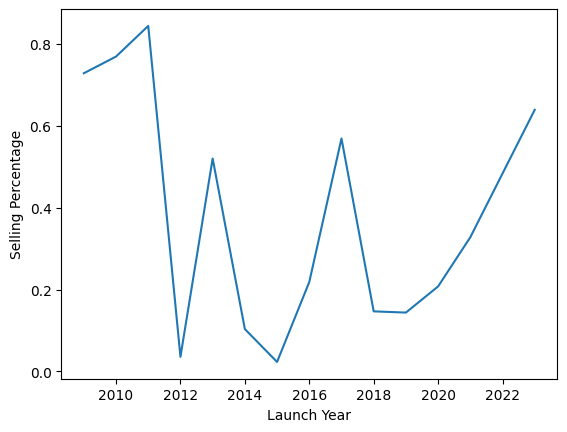

In [42]:
sale_progress_final.groupby('Launch Year').mean()['1st Year Sale Progress'].plot()
plt.ylabel('Selling Percentage')

In [43]:
sale_progress_final.to_csv('Sale Progress.csv')

## Real Estate Market Macro Data

In [44]:
# # import real estate macro market data
# MarketPriceIndex = pd.read_excel('/content/MarketPriceIndex_CCR.xlsx')
# MarketRentalIndex = pd.read_excel('/content/MarketRentalIndex_CCR.xlsx')
# VacancyRate = pd.read_excel('/content/MarketVaccancyRate.xlsx')
# UnitsSupply = pd.read_excel('/content/MarketUnitsSupply.xlsx')
# MacroMarket_data = MarketPriceIndex.merge(MarketRentalIndex, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.merge(VacancyRate, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.merge(UnitsSupply, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.rename(columns ={'Core Central Region_x': 'Price Index', 'Core Central Region_y' : 'Rental Index', 'Number of Units' : 'Units Supply'})
# MacroMarket_data.to_csv('MacroMarket_Data.csv')

In [45]:
MacroMarket_data = pd.read_csv('/content/MacroMarket_Data.csv')

In [46]:
MacroMarket_data['Quarter'] = pd.to_datetime(MacroMarket_data['Quarter'])
MacroMarket_data.set_index('Quarter', inplace = True)

In [47]:
MacroMarket_data[['Price Index','Rental Index', 'Vacancy Rate (%)', 'Units Supply']] = MacroMarket_data[['Price Index','Rental Index', 'Vacancy Rate (%)', 'Units Supply']].astype('float')

In [48]:
MacroMarket_data_resampled = MacroMarket_data.resample('M').first().interpolate()

In [49]:
MacroMarket_data_resampled.index = MacroMarket_data_resampled.index - pd.offsets.MonthBegin(1)

In [50]:
MacroMarket_data_resampled = MacroMarket_data_resampled.drop(columns = {'Unnamed: 0'})

In [51]:
MacroMarket_data_resampled['Price Index Gradient'] = MacroMarket_data_resampled['Price Index'].pct_change()

In [52]:
MacroMarket_data_resampled

,Price Index,Rental Index,Vacancy Rate (%),Units Supply,Price Index Gradient
Quarter,,,,,
2004-01-01,76.000000,63.300000,10.000000,50785.000000,NaN
2004-02-01,76.033333,63.366667,10.000000,50375.333333,0.000439
2004-03-01,76.066667,63.433333,10.000000,49965.666667,0.000438
2004-04-01,76.100000,63.500000,10.000000,49556.000000,0.000438
2004-05-01,76.200000,63.266667,10.066667,49109.666667,0.001314
...,...,...,...,...,...
2023-03-01,146.533333,154.300000,6.366667,53726.666667,-0.000227
2023-04-01,146.500000,155.300000,6.500000,54295.000000,-0.000227
2023-05-01,145.166667,154.433333,7.333333,51905.333333,-0.009101


## Macro Economic Data and Interest Rate

In [53]:
Macro_Data = pd.read_excel('/content/Macro_Economic_Data.xlsx', parse_dates= True)
Macro_Data = Macro_Data.set_index('Year')

In [54]:
Macro_Data_1 = Macro_Data[[ 'Capital Inflow', 'CPI', 'GDP']]
Macro_Data_2 = Macro_Data[['Singaporean 2nd Property ABSD', 'Foreigner ABSD']]
# Interpolation of data
Macro_Data_1 = Macro_Data_1.resample('M').interpolate()
Macro_Data_2 = Macro_Data_2.resample('M').ffill()
Macro_Data_final = Macro_Data_1.merge(Macro_Data_2, left_index = True, right_index = True)
Macro_Data_final = Macro_Data_final.reset_index()
Macro_Data_final['Sale Month'] = Macro_Data_final['Year'].dt.to_period('M').dt.to_timestamp()
Macro_Data_final = Macro_Data_final.drop(columns = 'Year')

In [55]:
Macro_Data_final

,Capital Inflow,CPI,GDP,Singaporean 2nd Property ABSD,Foreigner ABSD,Sale Month
0,0.187033,0.744350,0.432862,0.0,0.0,2000-12-01
1,0.188358,0.744979,0.431476,0.0,0.0,2001-01-01
2,0.189682,0.745608,0.430091,0.0,0.0,2001-02-01
3,0.191007,0.746238,0.428705,0.0,0.0,2001-03-01
4,0.192332,0.746867,0.427319,0.0,0.0,2001-04-01
...,...,...,...,...,...,...
272,1.538031,1.108264,1.177579,0.2,0.6,2023-08-01
273,1.528523,1.111334,1.180276,0.2,0.6,2023-09-01
274,1.519016,1.114405,1.182974,0.2,0.6,2023-10-01
275,1.509508,1.117475,1.185671,0.2,0.6,2023-11-01


In [56]:
# Insert Interest Rate Data
Interest_Data = pd.read_csv('/content/Domestic Interest Rates .csv')
Interest_Data = Interest_Data[~(Interest_Data['Year'] == 'SORA Value Date')]

In [57]:
Interest_Data['Interest Rate'] = Interest_Data['Interest Rate'].astype('float')
Interest_Data = Interest_Data.ffill()
Interest_Data_Final = Interest_Data.groupby(['Year','Month']).mean()
Interest_Data_Final = Interest_Data_Final[['Interest Rate']].reset_index()

In [58]:
Interest_Data_Final['Sale Month String'] = Interest_Data_Final['Year'].astype(str) + '-' + Interest_Data_Final['Month']
Interest_Data_Final = Interest_Data_Final[['Sale Month String', 'Interest Rate']]
Interest_Data_Final['Sale Date'] = pd.to_datetime(Interest_Data_Final['Sale Month String']) #, format='%Y-%b')
# Interest_Data_Final['Sale Month'] = Interest_Data_Final['Sale Date'].dt.to_period('M')
Interest_Data_Final = Interest_Data_Final.drop(columns = ['Sale Month String'])

In [59]:
Interest_Data_Final

,Interest Rate,Sale Date
0,6.548421,2000-12-01
1,4.622500,2001-04-01
2,3.562727,2001-08-01
3,1.926316,2001-12-01
4,5.354000,2001-02-01
...,...,...
272,3.348539,2023-03-01
273,3.611373,2023-05-01
274,3.753676,2023-11-01
275,3.717009,2023-10-01


## Merge the datas

In [60]:
data_merged = data.merge(MacroMarket_data_resampled, left_on = 'Sale Month', right_index = True, how = 'left')

In [61]:
data_merged

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,...,Sold in Second Year,Sold in Third Year,Sold in Fourth Year,Sold in Fifth Year,Launch Year,Price Index,Rental Index,Vacancy Rate (%),Units Supply,Price Index Gradient
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,...,0,0,0,0,2009,96.533333,96.6,6.8,63239.333333,-0.017639
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,...,0,0,0,0,2009,96.533333,96.6,6.8,63239.333333,-0.017639
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,...,0,0,0,0,2009,96.533333,96.6,6.8,63239.333333,-0.017639
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,...,0,0,0,0,2009,96.533333,96.6,6.8,63239.333333,-0.017639
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,...,0,0,0,0,2009,96.533333,96.6,6.8,63239.333333,-0.017639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,...,0,0,0,0,2023,NaN,NaN,NaN,NaN,NaN
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,...,0,0,0,1,2019,NaN,NaN,NaN,NaN,NaN
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,...,0,0,0,0,2023,NaN,NaN,NaN,NaN,NaN
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,...,0,0,0,0,2023,NaN,NaN,NaN,NaN,NaN


In [62]:
data_merged = data_merged.merge(sale_progress_final, left_on = 'Project Name', right_index = True, how = 'left')

In [63]:
data_merged = data_merged.merge(Macro_Data_final, left_on = 'Sale Month', right_on = 'Sale Month', how = 'left')

In [64]:
data_merged = data_merged.merge(Interest_Data_Final, left_on = 'Sale Month', right_on = 'Sale Date', how = 'left')

In [65]:
data_merged = data_merged[~(data_merged['Tenure'] == '99 years leasehold')]

In [126]:
data_merged['Remianing Tenure']

0        999.0
1        999.0
2        999.0
3        999.0
4        999.0
         ...  
10017    999.0
10018     93.0
10019    999.0
10020    999.0
10021    999.0
Name: Remianing Tenure, Length: 10021, dtype: float64

## Find the tenure and level

In [66]:
# calculate lease tenure
data_merged['Lease Commencement'] = data_merged['Tenure'].str.split(' ').str[-1].str.split('/').str[-1]
data_merged['Lease Commencement'].replace({'Freehold':'2024', '1875':'2024', '1877':'2024', '1841':'2024'},inplace = True)
data_merged['Lease Commencement'] = 2024 - data_merged['Lease Commencement'].astype('float')

In [67]:
data_merged['Total Tenure'] = np.where(data_merged['Tenure'].isin(['Freehold', '1875', '1877', '1841']), 999, 99)
data_merged['Remianing Tenure'] = data_merged['Total Tenure'] - data_merged['Lease Commencement']
data_merged['Remianing Tenure'].unique()

array([999.,  99.,  83.,  76.,  81.,  85.,  87.,  88.,  91.,  93.])

In [68]:
data_merged.rename(columns = {'Sale Date_x' : 'Sale Date'}, inplace = True)

In [69]:
data_merged['Sale Year'] = data_merged['Sale Year'].astype('int')

In [70]:
data_merged['Level Intermidiate'] = data_merged['Address'].str.split(' ').str[-1]
data_merged['Level'] = np.where(data_merged['Level Intermidiate'] == 'ETC', data_merged['Address'].str.split(' ').str[-2], data_merged['Level Intermidiate'])

In [71]:
data_merged['Level'] = data_merged['Level'].str.split('-').str[0].str.replace('#', '')
data_merged['Level'] = data_merged['Level'].replace({'ROAD' : 1})

In [72]:
data_merged['Level'] = data_merged['Level'].astype('float')

In [73]:
data_merged['Level'].unique()

array([14., 24., 22.,  2., 19., 27., 28., 26., 10.,  7., 31., 12.,  8.,
       23.,  4.,  3.,  9., 11.,  5., 18., 13., 16., 15., 21.,  6., 17.,
       20.,  1., 29., 30., 25., 33., 34., 35., 32., 36.])

In [74]:
Residencial_Analysis_Data = data_merged.dropna()

In [75]:
Residencial_Analysis_Data.columns

Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Tenure',
       'Completion Date', 'Postal District', 'Postal Sector', 'Planning Area',
       'BUILDING', 'LATITUDE', 'LONGITUDE', 'min_distance_to_mrt',
       'min_distance_to_star_school', 'Room Type', 'Sale Year', 'Sale Month',
       'Earliest Sale Month', 'Sale First Year', 'Sale Second Year',
       'Sale Third Year', 'Sale Fourth Year', 'Sold in First Year',
       'Sold in Second Year', 'Sold in Third Year', 'Sold in Fourth Year',
       'Sold in Fifth Year', 'Launch Year_x', 'Price Index', 'Rental Index',
       'Vacancy Rate (%)', 'Units Supply', 'Price Index Gradient',
       '1st Year Sale Progress', '2nd Year Sale Progress',
       '3rd Year Sale Progress', '4th Year Sale Progress',
       '5th Year Sale Progress', 'Sum', 'Launch Year_y', 'Capital Inflow',
       'CPI', 'GDP', 'Singaporean 2nd Property ABSD', 'Foreigner ABSD',
       'Interest Rate', 'Sale 

In [76]:
Residential_Data = Residencial_Analysis_Data[['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Tenure',
       'Completion Date', 'Postal District', 'Postal Sector', 'min_distance_to_mrt',
       'min_distance_to_star_school', 'Room Type', 'Sale Year', 'Sale Month',
       'Earliest Sale Month','Price Index', 'Rental Index', 'Vacancy Rate (%)',
       'Units Supply', 'Price Index Gradient', '1st Year Sale Progress',
       '2nd Year Sale Progress', '3rd Year Sale Progress',
       '4th Year Sale Progress', '5th Year Sale Progress', 'Sum',
       'Capital Inflow', 'CPI', 'GDP',
       'Singaporean 2nd Property ABSD', 'Foreigner ABSD', 'Interest Rate','Remianing Tenure','Level']]

In [77]:
Residential_Data['Unit Price ($ PSF)'] = Residential_Data['Unit Price ($ PSF)'].str.replace(',','').astype('float')

<ipython-input-77-22937aadc6ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Residential_Data['Unit Price ($ PSF)'] = Residential_Data['Unit Price ($ PSF)'].str.replace(',','').astype('float')


In [78]:
Residential_Data.to_csv('Residential_Data.csv')

## Check the Feature Importances

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

In [87]:
X = Residential_Data[['Postal Sector', 'min_distance_to_mrt','min_distance_to_star_school', 'Room Type', 'Price Index', 'Rental Index', 'Vacancy Rate (%)',
       'Units Supply', 'Price Index Gradient', 'Capital Inflow', 'CPI', 'GDP',
       'Singaporean 2nd Property ABSD', 'Foreigner ABSD', 'Interest Rate','Remianing Tenure','Level' ]].astype('float')
y = Residential_Data[['1st Year Sale Progress']]

In [81]:
X.columns.to_frame()

,0
Postal Sector,Postal Sector
min_distance_to_mrt,min_distance_to_mrt
min_distance_to_star_school,min_distance_to_star_school
Room Type,Room Type
Price Index,Price Index
Rental Index,Rental Index
Vacancy Rate (%),Vacancy Rate (%)
Units Supply,Units Supply
Price Index Gradient,Price Index Gradient
Capital Inflow,Capital Inflow


In [82]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y)
Score_RF_train = RF.score(X,y)
print('Training R score of Random Forest', Score_RF_train)

<ipython-input-82-304f5f0034fd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y)


Training R score of Random Forest 0.9992643142242217


Text(0.5, 1.0, 'Feature Importance for Sale Progress')

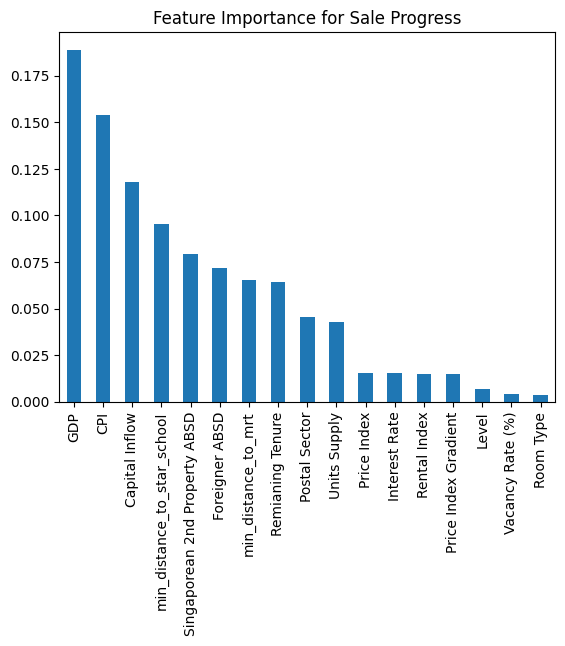

In [83]:
# Calculate Importance
importances = RF.feature_importances_
forest_importance = pd.Series(importances, index = X.columns)
forest_importance = forest_importance.sort_values(ascending = False)
forest_importance.plot.bar()
plt.title('Feature Importance for Sale Progress')

In [84]:
y_price = Residential_Data['Unit Price ($ PSF)']
# Random Forest
RF_price=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y_price)
Score_RF_train_price = RF_price.score(X,y_price)
print('Training R score of Random Forest', Score_RF_train_price)

Training R score of Random Forest 0.9818804431326459


Text(0.5, 1.0, 'Feature Importance for Sale Price')

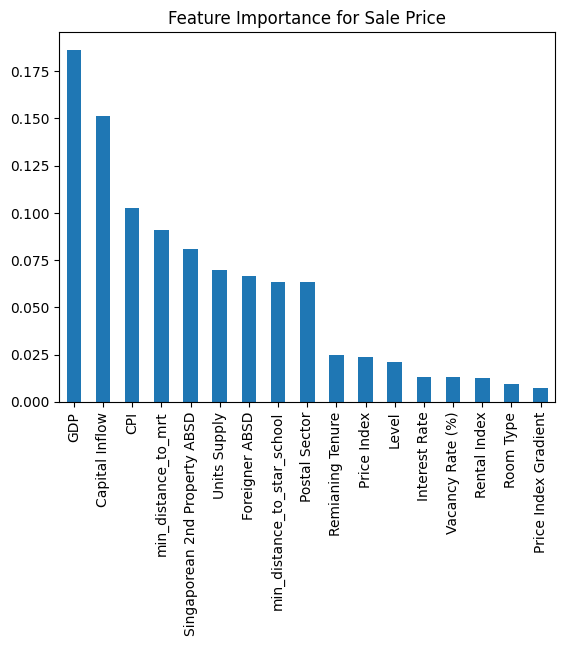

In [85]:
# Calculate Importance
importances = RF_price.feature_importances_
forest_importance = pd.Series(importances, index = X.columns)
forest_importance = forest_importance.sort_values(ascending = False)
forest_importance.plot.bar()
plt.title('Feature Importance for Sale Price')

In [86]:
Ridge_ML=Ridge(alpha=0.2).fit(X,y_price)
Score_Ridge_train = Ridge_ML.score(X,y_price)
print('Training R score of Ridge', Score_Ridge_train)

Training R score of Ridge 0.8255101994749859


## Machine Learning for sale progress

In [90]:
# using LinearRegression, Ridge, Lasso, RandomForest, GradientBoostingTree,NaiveBayes,SVM and NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 0)

In [91]:
# Linear Regression
lr=LinearRegression().fit(X_train,y_train)
Score_linear_train = lr.score(X_train,y_train)
Score_linear_test = lr.score(X_test,y_test)
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)

Training R score of linear regression 0.7571046839784581
Testing R score of linear regression 0.7299692773176963


In [92]:
# Ridge
Ridge_ML=Ridge(alpha=0.2).fit(X_train,y_train)
Score_Ridge_train = Ridge_ML.score(X_train,y_train)
Score_Ridge_test = Ridge_ML.score(X_test,y_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)

Training R score of Ridge 0.7561360755682156
Testing R score of Ridge 0.7287444226875577


In [93]:
# Lasso
Lasso_ML=Lasso(alpha=0.2).fit(X_train,y_train)
Score_Lasso_train = Lasso_ML.score(X_train,y_train)
Score_Lasso_test = Lasso_ML.score(X_test,y_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)

Training R score of Lasso 0.5723410320495098
Testing R score of Lasso 0.5412996982713185


In [94]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)
Score_RF_train = RF.score(X_train,y_train)
Score_RF_test = RF.score(X_test,y_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)

<ipython-input-94-5bf91fdd5f71>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)


Training R score of Random Forest 0.9992215092588301
Testing R score of Random Forest 0.9951484776365995


In [96]:
# Gradient Boosted Tree
GB = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB.fit(X_train, y_train)
Score_GB_train = GB.score(X_train,y_train)
Score_GB_test = GB.score(X_test,y_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of Gradient Boosted Tree 0.9999530904123924
Testing R score of Gradient Boosted Tree 0.9970017758281248


In [130]:
# For Prediction
GB_sale_progress = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB_sale_progress.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                          n_estimators=500, random_state=0)

In [97]:
# SVM (poly)
svm1 = svm.SVR(kernel = 'poly', C = 1.0)
svm1.fit(X_train, y_train)
Score_SVM1_train = svm1.score(X_train,y_train)
Score_SVM1_test = svm1.score(X_test,y_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
# SVM (Gaussian)
svm2 = svm.SVR(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm2.fit(X_train, y_train)
Score_SVM2_train = svm2.score(X_train,y_train)
Score_SVM2_test = svm2.score(X_test,y_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of SVM (poly) 0.3881085176004091
Testing R score of SVM (poly) 0.3635626833523794


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of SVM (Gaussian) 0.49200075169764623
Testing R score of SVM (Gaussian) 0.4446445925660869


In [104]:
# Neural Network
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Dense(units = 4, activation = 'sigmoid'))
NN.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
NN.compile(optimizer = 'adam', loss = 'mean_absolute_error')
result = NN.fit(X_train, y_train, batch_size = 50, epochs = 100)

Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 2155.0349
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 2154.9463
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 2154.8323
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 2154.7085
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 2154.5969
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 2154.5103
Epoch 7/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.4460
Epoch 8/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.4014
Epoch 9/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.3711
Epoch 10/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.3481
Epoch 11/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.3291
Epoch 12/100
107/107 [==============================] - 0s 2ms/

In [99]:
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)
r2_value_train = r2_score(y_train, y_train_pred)
r2_value_test = r2_score(y_test, y_test_pred)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

42/42 [==============================] - 0s 1ms/step
R2 Score on training data: -18.11087529691483
R2 Score on testing data: -20.202369576167893


In [101]:
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)
# print('Training R score of Naive Bayes', Score_NB_train)
# print('Testing R score of Naive Bayes', Score_NB_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

Training R score of linear regression 0.7571046839784581
Testing R score of linear regression 0.7299692773176963
Training R score of Ridge 0.7561360755682156
Testing R score of Ridge 0.7287444226875577
Training R score of Lasso 0.5723410320495098
Testing R score of Lasso 0.5412996982713185
Training R score of Random Forest 0.9992215092588301
Testing R score of Random Forest 0.9951484776365995
Training R score of Gradient Boosted Tree 0.9999530904123924
Testing R score of Gradient Boosted Tree 0.9970017758281248
Training R score of SVM (poly) 0.3881085176004091
Testing R score of SVM (poly) 0.3635626833523794
Training R score of SVM (Gaussian) 0.49200075169764623
Testing R score of SVM (Gaussian) 0.4446445925660869
R2 Score on training data: -18.11087529691483
R2 Score on testing data: -20.202369576167893


## Machine Learning for Sale Price

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X,y_price, test_size = 0.2, random_state= 0)

In [105]:
# Linear Regression
lr=LinearRegression().fit(X_train,y_train)
Score_linear_train = lr.score(X_train,y_train)
Score_linear_test = lr.score(X_test,y_test)
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)

Training R score of linear regression 0.8277294680376714
Testing R score of linear regression 0.8199830426455978


In [107]:
# Ridge
Ridge_ML=Ridge(alpha=0.2).fit(X_train,y_train)
Score_Ridge_train = Ridge_ML.score(X_train,y_train)
Score_Ridge_test = Ridge_ML.score(X_test,y_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)

Training R score of Ridge 0.8266447346509954
Testing R score of Ridge 0.819017753689572


In [108]:
# Lasso
Lasso_ML=Lasso(alpha=0.2).fit(X_train,y_train)
Score_Lasso_train = Lasso_ML.score(X_train,y_train)
Score_Lasso_test = Lasso_ML.score(X_test,y_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)

Training R score of Lasso 0.8230671480026077
Testing R score of Lasso 0.815370059755468


In [109]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)
Score_RF_train = RF.score(X_train,y_train)
Score_RF_test = RF.score(X_test,y_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)

Training R score of Random Forest 0.9820206465977896
Testing R score of Random Forest 0.9682425141335208


In [110]:
# Gradient Boosted Tree
GB = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB.fit(X_train, y_train)
Score_GB_train = GB.score(X_train,y_train)
Score_GB_test = GB.score(X_test,y_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)

Training R score of Gradient Boosted Tree 0.9927956536670444
Testing R score of Gradient Boosted Tree 0.9753944350542068


In [132]:
# For Prediction
GB_sale_price = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB_sale_price.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                          n_estimators=500, random_state=0)

In [111]:
# SVM (poly)
svm1 = svm.SVR(kernel = 'poly', C = 1.0)
svm1.fit(X_train, y_train)
Score_SVM1_train = svm1.score(X_train,y_train)
Score_SVM1_test = svm1.score(X_test,y_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
# SVM (Gaussian)
svm2 = svm.SVR(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm2.fit(X_train, y_train)
Score_SVM2_train = svm2.score(X_train,y_train)
Score_SVM2_test = svm2.score(X_test,y_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)

Training R score of SVM (poly) 0.3706028451667248
Testing R score of SVM (poly) 0.3798909704782619
Training R score of SVM (Gaussian) 0.2915796831252544
Testing R score of SVM (Gaussian) 0.30745684452767863


In [115]:
# Neural Network
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Dense(units = 8, activation = 'sigmoid'))
NN.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
NN.compile(optimizer = 'adam', loss = 'mean_absolute_error')
result = NN.fit(X_train, y_train, batch_size = 50, epochs = 100)

Epoch 1/100
107/107 [==============================] - 1s 2ms/step - loss: 2154.3550
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.3140
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2908
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2751
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2683
Epoch 6/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2656
Epoch 7/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2625
Epoch 8/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2598
Epoch 9/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2544
Epoch 10/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2527
Epoch 11/100
107/107 [==============================] - 0s 2ms/step - loss: 2154.2524
Epoch 12/100
107/107 [==============================] - 0s 2ms/

In [116]:
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)
r2_value_train = r2_score(y_train, y_train_pred)
r2_value_test = r2_score(y_test, y_test_pred)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

42/42 [==============================] - 0s 1ms/step
R2 Score on training data: -12.03283504450569
R2 Score on testing data: -11.834336917798653


In [114]:
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)
# print('Training R score of Naive Bayes', Score_NB_train)
# print('Testing R score of Naive Bayes', Score_NB_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

Training R score of linear regression 0.8277294680376714
Testing R score of linear regression 0.8199830426455978
Training R score of Ridge 0.8266447346509954
Testing R score of Ridge 0.819017753689572
Training R score of Lasso 0.8230671480026077
Testing R score of Lasso 0.815370059755468
Training R score of Random Forest 0.9820206465977896
Testing R score of Random Forest 0.9682425141335208
Training R score of Gradient Boosted Tree 0.9927956536670444
Testing R score of Gradient Boosted Tree 0.9753944350542068
Training R score of SVM (poly) 0.3706028451667248
Testing R score of SVM (poly) 0.3798909704782619
Training R score of SVM (Gaussian) 0.2915796831252544
Testing R score of SVM (Gaussian) 0.30745684452767863
R2 Score on training data: -12.032838688757014
R2 Score on testing data: -11.834340524882679


## Prediction

In [124]:
loc_lat = 1.291899
loc_lng = 103.841475
min_distance = float('inf')
for mrt_index, mrt_row in mrt.iterrows():
    mrt_lat = mrt_row['lat']
    mrt_lng = mrt_row['lng']
    distance = haversine(loc_lat, loc_lng, mrt_lat, mrt_lng)
    if distance < min_distance:
        min_distance = distance
min_distance

0.3509976670959466

In [125]:
loc_lat = 1.291899
loc_lng = 103.841475
min_distance = float('inf')
for school_index, school_row in school_loc.iterrows():
    school_lat = school_row['LATITUDE']
    school_lng = school_row['LONGITUDE']
    distance = haversine(loc_lat, loc_lng, school_lat, school_lng)
    if distance < min_distance:
        min_distance = distance
min_distance

3.014851535564376

In [135]:
input = pd.read_excel('/content/Input_Features_for_Unity.xlsx',index_col='Features')

In [160]:
prediction = np.array(input.values.squeeze())

In [161]:
prediction = prediction.reshape(-1,1)

In [162]:
prediction = prediction.transpose()

In [163]:
prediction

array([[2.300000e+01, 3.509970e-01, 3.014850e+00, 2.000000e+00,
        1.425000e+02, 1.500000e+02, 7.500000e+00, 5.573100e+04,
        5.000000e-03, 1.500000e+00, 1.158597e+00, 1.211760e+00,
        2.000000e-01, 6.000000e-01, 3.500000e+00, 9.990000e+02,
        5.000000e+00]])

In [164]:
Progress = GB_sale_progress.predict(prediction)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [165]:
Progress

array([0.34966056])

In [166]:
price = GB_sale_price.predict(prediction)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [167]:
price

array([2934.11920557])